In [1]:
import os
import sys
import shutil
import time

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.linewidth'] = 1.25


# import dustpy as dp
from dustpy import Simulation
from dustpy import constants as c


print("Done")


A newer version of DustPy is available.
This version:   1.0.5
Latest version: 1.0.6

Upgrade with
pip install dustpy --upgrade

Done


In [2]:
# Define Necessary Functions

def convert(S, m):
    """Function converts the Dustpy units into number densities.

    Parameters
    ----------
    S : array
        Integrated surface density in DustPy units
    m : array
        mass grid

    Returns
    -------
    Nm2 : array
        Simulation results in desired units for comparison"""
    A = np.mean(m[1:]/m[:-1])
    B = 2 * (A-1) / (A+1)
    return S / B

def solution_constant_kernel(t, m, a, S0):
    """Analytical solution of the constant collision kernel R(m, m') = a.
    Initial condition is that only the zeroth mass bin is filled.

    Parameters
    ----------
    t : float
        Time
    m : Field
        Mass grid
    a : float
        Kernel constant
    S0 : float
        Total dust surface density

    Returns
    -------
    Nm2 : Field
        Analytical solution in desired units."""
    m0 = m[0]
    N0 = S0 / m0
    return N0 / m0 * 4./(a*N0*t)**2 * np.exp( (1.-m/m0) * 2/(a*N0*t) ) * m**2

def solution_linear_kernel(t, m, a, S0):
    """Analytical solution of the linear collision kernel R(m, m') = a(m + m').
    Initial condition is that only the zeroth mass bin is filled.

    Parameters
    ----------
    t : float
        Time
    m : Field
        Mass grid
    a : float
        Kernel constant
    S0 : float
        Total dust surface density

    Returns
    -------
    Nm2 : Field
        Analytical solution in desired units."""
    m0 = m[0]
    N0 = S0/m0**2
    g = np.exp(-a*S0*t)
    #N = 1./m0**2 * g * np.exp( -m/m0 * ( 1. - np.sqrt(1-g) )**2 ) / ( 2.*np.sqrt(np.pi) * (m/m0)**1.5 * (1.-g)**0.75 )
    N = N0 * g * np.exp( -m/m0 * ( 1. - np.sqrt(1-g) )**2 ) / ( 2.*np.sqrt(np.pi) * (m/m0)**1.5 * (1.-g)**0.75 )
    return N*m**2



def set_constant_kernel(sim, a, S0):
    """Function set the ``DustPy`` simulation object up for the constant collision kernel R(m, m') = a.

    sim : Frame
        Simulation object
    a : float
        Kernel constant
    S0 : float
        Total dust surface density"""
    # Turning off gas evolution by removing integrator instruction
    del(sim.integrator.instructions[1])
    # Turning off gas source to not influence the time stepping
    sim.gas.S.tot[...] = 0.
    sim.gas.S.tot.updater = None
    # Turning off dust advection
    sim.dust.v.rad[...] = 0.
    sim.dust.v.rad.updater = None
    # Turning off fragmentation. Only sticking is considered
    sim.dust.p.frag[...] = 0.
    sim.dust.p.frag.updater = None
    sim.dust.p.stick[...] = 1.
    sim.dust.p.stick.updater = None
    # Setting the constant kernel
    sim.dust.kernel[...] = a
    sim.dust.kernel.updater = None
    # Setting the initial time
    sim.t = 1.e-9
    # Setting the initial dust surface density
    m = sim.grid.m
    A = np.mean(m[1:]/m[:-1])
    B = 2 * (A-1) / (A+1)
    sim.dust.Sigma[...] = sim.dust.SigmaFloor[...]
    sim.dust.Sigma[1, :] = np.maximum(solution_constant_kernel(sim.t, m, a, S0)*B, sim.dust.SigmaFloor[1, :])
    # Updating the simulation object
    sim.update()

def set_linear_kernel(sim, a, S0):
    """Function set the ``DustPy`` simulation object up for the linear collision kernel R(m, m') = a(m + m').

    sim : Frame
        Simulation object
    a : float
        Kernel constant
    S0 : float
        Total dust surface density"""
    # Turning off gas evolution by removing integrator instruction
    del(sim.integrator.instructions[1])
    # Turning off gas source to not influence the time stepping
    sim.gas.S.tot[...] = 0.
    sim.gas.S.tot.updater = None
    # Turning off dust advection
    sim.dust.v.rad[...] = 0.
    sim.dust.v.rad.updater = None
    # Turning off fragmentation. Only sticking is considered
    sim.dust.p.frag[...] = 0.
    sim.dust.p.frag.updater = None
    sim.dust.p.stick[...] = 1.
    sim.dust.p.stick.updater = None
    # Setting the constant kernel
    sim.dust.kernel[...] = a * (sim.grid.m[:, None] + sim.grid.m[None, :])[None, ...]
    sim.dust.kernel.updater = None
    # Setting the initial time
    sim.t = 1.e0
    # Setting the initial dust surface density
    m = sim.grid.m
    A = np.mean(m[1:]/m[:-1])
    B = 2 * (A-1) / (A+1)
    sim.dust.Sigma[...] = sim.dust.SigmaFloor[...]
    sim.dust.Sigma[1, ...] = np.maximum(solution_linear_kernel(sim.t, m, a, S0) * B, sim.dust.SigmaFloor[1, ...])
    # Updating the simulation object
    sim.update()

In [9]:
start = time.time()
# CONSTANT KERNEL

# create simulation
sim = Simulation()

# Change ini params and initialize simulation

sim.ini.dust.allowDriftingParticles = False
sim.ini.grid.Nr = 3
sim.ini.grid.Nmbpd = 7

sim.initialize()

# Run test coagulation simulation with constant kernel

a = 1.
S0 = 1.

set_constant_kernel(sim, a, S0)
snapshots = np.logspace(-7., 3., 7)
sim.t.snapshots = snapshots

output_dir = "outputs/test_constant_kernel"
shutil.rmtree(output_dir)
sim.writer.datadir = output_dir

sim.run()

end = time.time()
print(f"Elapsed time: {end-start} s")

# Read output

SigmaConstant = sim.writer.read.sequence("dust.Sigma")
m = sim.writer.read.sequence("grid.m")
t = sim.writer.read.sequence("t")

end = time.time()
print(f"Elapsed time: {end-start} s")


DustPy v1.0.5

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.82e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  5.55e-16
        for particle collision
            m[113] =  1.39e+04 g    with
            m[119] =  1.00e+05 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory 'outputs/test_constant_kernel'.
Writing file outputs/test_constant_kernel/data0000.hdf5
Writing dump file outputs/test_constant_kernel/frame.dmp
Writing file outputs/test_constant_kernel/data0001.hdf5
Writing dump file outputs/test_constant_kernel/frame.d

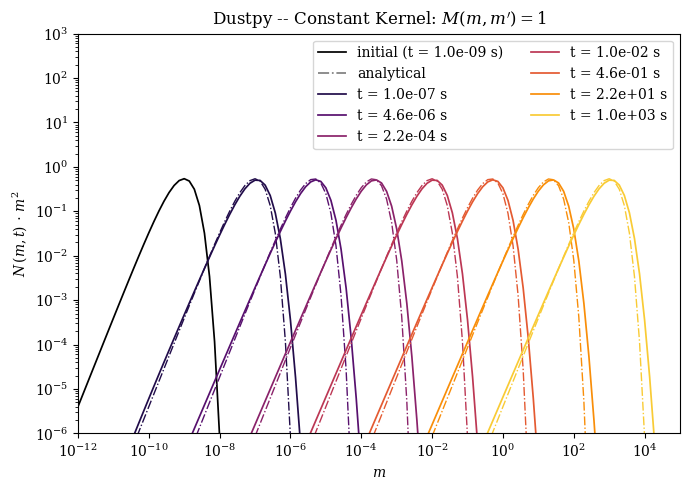

In [10]:
# Plot constant kernel output

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.loglog(m[0, ...], convert(SigmaConstant[0, 1, :], m[0, ...]), c="black", label="initial (t = 1.0e-09 s)")
ax.plot(0., 0., "-.", c="black", label="analytical", alpha=0.5)

couleurs = plt.cm.inferno(np.linspace(0,1,len(t)+1))
for i in range(1, len(t)):
    cstr = couleurs[i] # "C" + str(i-1)
    ax.loglog(m[i,:], convert(SigmaConstant[i,1,:], m[i,:]), c=cstr, label="t = {:3.1e} s".format(t[i]))
    ax.loglog(m[i,:], solution_constant_kernel(t[i], m[i,:], a, S0), lw=1, ls="-.", c=cstr)

ax.legend(ncol=2)
ax.set_xlim(m[0, 0], m[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"$m$", math_fontfamily='dejavuserif')
ax.set_ylabel(r"$N\,\left(m,t\right)\,\cdot\,m^2$", math_fontfamily='dejavuserif')
ax.set_title(r"Dustpy -- Constant Kernel: $M\left( m, m'\right) = 1$", math_fontfamily='dejavuserif')
fig.tight_layout()
plt.savefig(str(sim.writer.datadir)+"_lowres.png", dpi=300)
plt.show()

In [17]:
# LINEAR KERNEL
start = time.time()

# create simulation
sim = Simulation()

# Change ini params and initialize simulation

sim.ini.dust.allowDriftingParticles = True
sim.ini.grid.Nr = 3
sim.ini.grid.Nmbpd = 7

sim.initialize()

# Run test coagulation simulation with constant kernel

a = 1.
S0 = 1.

set_linear_kernel(sim, a, S0)
snapshots = np.logspace(0,1.2,7)
sim.t.snapshots = snapshots

output_dir = "outputs/test_linear_kernel"
shutil.rmtree(output_dir)
sim.writer.datadir = output_dir
sim.run()

# Read output

SigmaLinear = sim.writer.read.sequence("dust.Sigma")
m = sim.writer.read.sequence("grid.m")
t = sim.writer.read.sequence("t")

end = time.time()
print(f"Elapsed time: {end-start} s")


DustPy v1.0.5

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.82e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  5.55e-16
        for particle collision
            m[113] =  1.39e+04 g    with
            m[119] =  1.00e+05 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory 'outputs/test_linear_kernel'.
Writing file outputs/test_linear_kernel/data0002.hdf5
Writing dump file outputs/test_linear_kernel/frame.dmp
Writing file outputs/test_linear_kernel/data0003.hdf5
Writing dump file outputs/test_linear_kernel/frame.dmp
Writing

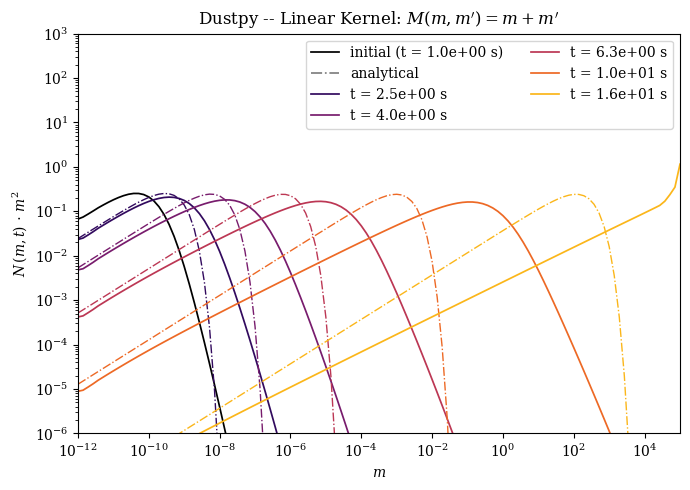

In [18]:
# Plot linear kernel output

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.loglog(m[0, ...], convert(SigmaLinear[0, 1, :], m[0, ...]), c="black", label="initial (t = 1.0e+00 s)")
ax.plot(0., 0., "-.", c="black", label="analytical", alpha=0.5)

couleurs = plt.cm.inferno(np.linspace(0,1,len(t)+1))
for i in range(1,len(t)):
    cstr = couleurs[i] # "C" + str(i-1)
    ax.loglog(m[i, ...], convert(SigmaLinear[i, 1, :], m[i, ...]), lw=1.25, c=cstr, label="t = {:3.1e} s".format(t[i]))
    ax.loglog(m[i, ...], solution_linear_kernel(t[i], m[i, ...], a, S0), "-.", lw=1, c=cstr)
ax.legend(ncol=2)
ax.set_xlim(m[0, 0], m[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"$m$", math_fontfamily='dejavuserif')
ax.set_ylabel(r"$N\,\left(m,t\right)\,\cdot\,m^2$", math_fontfamily='dejavuserif')
ax.set_title(r"Dustpy -- Linear Kernel: $M\left( m, m'\right) = m + m'$", math_fontfamily='dejavuserif')
fig.tight_layout()
plt.savefig(str(sim.writer.datadir)+".png", dpi=300)
plt.show()